In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle

import glob
from PIL import Image


/common/home/ab2167/.conda/envs/ml3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Utilities

# dataset_utility
class ToTensor(object):
    def __call__(self, sample):
        return torch.tensor(sample, dtype=torch.float32)

class dataset(Dataset):
    def __init__(self, root_dir, dataset_type, img_size, transform=None, shuffle=False):
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = [f for f in glob.glob(os.path.join(root_dir, "*", "*.npz")) \
                            if dataset_type in f]
        self.img_size = img_size
        #with open(os.path.join(root_dir, 'embedding.npy'), "rb") as fd:
        #  self.embeddings = pickle.load(fd, fix_imports=True, encoding="latin1")

        #self.embeddings = np.load(os.path.join(root_dir, 'embedding.npy'), allow_pickle=True, encoding="latin1")
        self.shuffle = shuffle

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        data_path = self.file_names[idx]
        data = np.load(data_path)
        image = data["image"].reshape(16, 160, 160)
        target = data["target"]
        structure = data["structure"]
        meta_target = data["meta_target"]
        meta_structure = data["meta_structure"]

        if self.shuffle:
            context = image[:8, :, :]
            choices = image[8:, :, :]
            indices = range(8)
            np.random.shuffle(indices)
            new_target = indices.index(target)
            new_choices = choices[indices, :, :]
            image = np.concatenate((context, new_choices))
            target = new_target
        
        resize_image = []
        for idx in range(0, 16):
            resize_image.append(np.array(Image.fromarray(image[idx,:,:]).resize((self.img_size, self.img_size))))
        resize_image = np.stack(resize_image)

        '''
        embedding = torch.zeros((6, 300), dtype=torch.float)
        indicator = torch.zeros(1, dtype=torch.float)
        element_idx = 0
        for element in structure:
            if element != '/':
                embedding[element_idx, :] = torch.tensor(self.embeddings.item().get(element), dtype=torch.float)
                element_idx += 1
        if element_idx == 6:
            indicator[0] = 1.
        '''
        del data
        if self.transform:
            resize_image = self.transform(resize_image)
            target = torch.tensor(target, dtype=torch.long)
            meta_target = self.transform(meta_target)
            meta_structure = self.transform(meta_structure)
        #return resize_image, target, meta_target, meta_structure, embedding, indicator
        return resize_image, target, meta_target, meta_structure

# fc_tree_net

class FCTreeNet(torch.nn.Module):
    def __init__(self, in_dim=300, img_dim=256, use_cuda=True):
        '''
        initialization for TreeNet model, basically a ChildSumLSTM model
        with non-linear activation embedding for different nodes in the AoG.
        Shared weigths for all LSTM cells.
        :param in_dim:      input feature dimension for word embedding (from string to vector space)
        :param img_dim:     dimension of the input image feature, should be (panel_pair_number * img_feature_dim (e.g. 512 or 256))
        '''
        super(FCTreeNet, self).__init__()
        self.in_dim = in_dim
        self.img_dim = img_dim
        self.fc = nn.Linear(self.in_dim, self.in_dim)
        self.leaf = nn.Linear(self.in_dim + self.img_dim, self.img_dim)
        self.middle = nn.Linear(self.in_dim + self.img_dim, self.img_dim)
        self.merge = nn.Linear(self.in_dim + self.img_dim, self.img_dim)
        self.root = nn.Linear(self.in_dim + self.img_dim, self.img_dim)

        self.relu = nn.ReLU()

    def forward(self, image_feature, input, indicator):
        '''
        Forward funciton for TreeNet model
        :param input:		input should be (batch_size * 6 * input_word_embedding_dimension), got from the embedding vector
        :param indicator:	indicating whether the input is of structure with branches (batch_size * 1)
        :param image_feature:   input dictionary for each node, primarily feature, for example (batch_size * 16 (panel_pair_number) * feature_dim (output from CNN))
        :return:
        '''
        # image_feature = image_feature.view(-1, 16, image_feature.size(2))
        input = self.fc(input.view(-1, input.size(-1)))
        input = input.view(-1, 6, input.size(-1))
        input = input.unsqueeze(1).repeat(1, image_feature.size(1), 1, 1)
        indicator = indicator.unsqueeze(1).repeat(1, image_feature.size(1), 1).view(-1, 1)

        leaf_left = input[:, :, 3, :].view(-1, input.size(-1))           # (batch_size * panel_pair_num) * input_word_embedding_dimension
        leaf_right = input[:, :, 5, :].view(-1, input.size(-1))
        inter_left = input[:, :, 2, :].view(-1, input.size(-1))
        inter_right = input[:, :, 4, :].view(-1, input.size(-1))
        merge = input[:, :, 1, :].view(-1, input.size(-1))
        root = input[:, :, 0, :].view(-1, input.size(-1))
        
        # concating image_feature and word_embeddings for leaf node inputs
        leaf_left = torch.cat((leaf_left, image_feature.view(-1, image_feature.size(-1))), dim=-1)
        leaf_right = torch.cat((leaf_right, image_feature.view(-1, image_feature.size(-1))), dim=-1)

        out_leaf_left = self.leaf(leaf_left)
        out_leaf_right = self.leaf(leaf_right)

        out_leaf_left = self.relu(out_leaf_left)
        out_leaf_right = self.relu(out_leaf_right)

        out_left = self.middle(torch.cat((inter_left, out_leaf_left), dim=-1))
        out_right = self.middle(torch.cat((inter_right, out_leaf_right), dim=-1))

        out_left = self.relu(out_left)
        out_right = self.relu(out_right)

        out_right = torch.mul(out_right, indicator)
        merge_input = torch.cat((merge, out_left + out_right), dim=-1)
        out_merge = self.merge(merge_input)

        out_merge = self.relu(out_merge)

        out_root = self.root(torch.cat((root, out_merge), dim=-1))
        out_root = self.relu(out_root)
        # size ((batch_size * panel_pair) * feature_dim)
        return out_root

# Basic Model

class BasicModel(nn.Module):
    def __init__(self, args):
        super(BasicModel, self).__init__()
        self.name = args.model
    
    def load_model(self, path, epoch):
        state_dict = torch.load(path+'{}_epoch_{}.pth'.format(self.name, epoch))['state_dict']
        self.load_state_dict(state_dict)

    def save_model(self, path, epoch, acc, loss):
        torch.save({'state_dict': self.state_dict(), 'acc': acc, 'loss': loss}, path+'{}_epoch_{}.pth'.format(self.name, epoch))

    def compute_loss(self, output, target, meta_target, meta_structure):
        pass

    def train_(self, image, target, meta_target, meta_structure):
        self.optimizer.zero_grad()
        #output = self(image, embedding, indicator)
        output = self(image)
        loss = self.compute_loss(output, target, meta_target, meta_structure)
        loss.backward()
        self.optimizer.step()
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        accuracy = correct * 100.0 / target.size()[0]
        return loss.item(), accuracy

    def validate_(self, image, target, meta_target, meta_structure):
        with torch.no_grad():
            #output = self(image, embedding, indicator)
            output = self(image)
        loss = self.compute_loss(output, target, meta_target, meta_structure)
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        accuracy = correct * 100.0 / target.size()[0]
        return loss.item(), accuracy

    def test_(self, image, target, meta_target, meta_structure):
        with torch.no_grad():
            #output = self(image, embedding, indicator)
            output = self(image)
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        accuracy = correct * 100.0 / target.size()[0]
        return accuracy

class conv_module(nn.Module):
    def __init__(self):
        super(conv_module, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
        self.batch_norm4 = nn.BatchNorm2d(32)
        self.relu4 = nn.ReLU()
        # self.fc = nn.Linear(32*4*4, 256)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(self.batch_norm1(x))
        x = self.conv2(x)
        x = self.relu2(self.batch_norm2(x))
        x = self.conv3(x)
        x = self.relu3(self.batch_norm3(x))
        x = self.conv4(x)
        x = self.relu4(self.batch_norm4(x))
        return x.view(-1, 16, 32*4*4)

class mlp_f1(nn.Module):
    def __init__(self):
        super(mlp_f1, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 256)


    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        return x.view(-1, 256)    

class mlp_f2(nn.Module):
    def __init__(self):
        super(mlp_f2, self).__init__()
        self.fc1 = nn.Linear(512, 512)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 256)


    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        return x.view(-1, 256)
    
    
class panels_to_embeddings(nn.Module):
    def __init__(self, tag):
        super(panels_to_embeddings, self).__init__()
        self.in_dim = 512
        if tag:
            self.in_dim += 9
        self.fc = nn.Linear(self.in_dim, 256)

    def forward(self, x):
        return self.fc(x.view(-1, self.in_dim))

    
class IWReN(BasicModel):
    def __init__(self, args):
        super(IWReN, self).__init__(args)
        self.conv = conv_module()
        self.rn = relation_module()
        self.mlp = mlp_module()
        self.mlp_f1 = mlp_f1()
        self.mlp_f2 = mlp_f2()
        self.cos = nn.CosineSimilarity(dim=2)
        self.proj = panels_to_embeddings(args.tag)
        self.optimizer = optim.Adam(self.parameters(), lr=args.lr, betas=(args.beta1, args.beta2), eps=args.epsilon)
        self.meta_beta = args.meta_beta 
        self.use_tag = args.tag
        self.use_cuda = args.cuda
        self.tags = self.tag_panels(args.batch_size)

    def tag_panels(self, batch_size):
        tags = []
        for idx in range(0, 16):
            tag = np.zeros([1, 9], dtype=float)
            if idx < 8:
                tag[:, idx] = 1.0
            else:
                tag[:, 8] = 1.0
            tag = torch.tensor(tag, dtype=torch.float).expand(batch_size, -1).unsqueeze(1)
            if self.use_cuda:
                tag = tag.cuda()
            tags.append(tag)
        tags = torch.cat(tags, dim=1)
        return tags

    def group_panel_embeddings(self, embeddings):
        embeddings = embeddings.view(-1, 16, 256)
        embeddings_seq = torch.chunk(embeddings, 16, dim=1)
        context_pairs = []
        for context_idx1 in range(0, 8):
            for context_idx2 in range(0, 8):
                if not context_idx1 == context_idx2:
                    context_pairs.append(torch.cat((embeddings_seq[context_idx1], embeddings_seq[context_idx2]), dim=2))
        context_pairs = torch.cat(context_pairs, dim=1)
        panel_embeddings_pairs = []
        for answer_idx in range(8, len(embeddings_seq)):
            embeddings_pairs = context_pairs
            for context_idx in range(0, 8):
                # In order
                order = torch.cat((embeddings_seq[answer_idx], embeddings_seq[context_idx]), dim=2)
                reverse = torch.cat((embeddings_seq[context_idx], embeddings_seq[answer_idx]), dim=2)
                choice_pairs = torch.cat((order, reverse), dim=1)
                embeddings_pairs = torch.cat((embeddings_pairs, choice_pairs), dim=1)
            panel_embeddings_pairs.append(embeddings_pairs.unsqueeze(1))
        panel_embeddings_pairs = torch.cat(panel_embeddings_pairs, dim=1)
        return panel_embeddings_pairs.view(-1, 8, 72, 512)

    def group_panel_embeddings_batch(self, embeddings):
        embeddings = embeddings.view(-1, 16, 256)
        context_embeddings = embeddings[:,:8,:]
        choice_embeddings = embeddings[:,8:,:]
        context_embeddings_pairs = torch.cat((context_embeddings.unsqueeze(1).expand(-1, 8, -1, -1), context_embeddings.unsqueeze(2).expand(-1, -1, 8, -1)), dim=3).view(-1, 64, 512)
        
        context_embeddings = context_embeddings.unsqueeze(1).expand(-1, 8, -1, -1)
        choice_embeddings = choice_embeddings.unsqueeze(2).expand(-1, -1, 8, -1)
        choice_context_order = torch.cat((context_embeddings, choice_embeddings), dim=3)
        choice_context_reverse = torch.cat((choice_embeddings, context_embeddings), dim=3)
        embedding_paris = [context_embeddings_pairs.unsqueeze(1).expand(-1, 8, -1, -1), choice_context_order, choice_context_reverse]
        return torch.cat(embedding_paris, dim=2).view(-1, 8, 80, 512)

    def temp_panel_embeddings(self, embeddings):
        embeddings = embeddings.view(-1, 16, 256)
        context_embeddings, choice_embeddings = embeddings[:,:8,:], embeddings[:,8:,:]
        
        #generating f1 tensor
        r1f1 = torch.cat((context_embeddings[:, 0, :],context_embeddings[:, 1, :],context_embeddings[:, 2, :]), dim=1).unsqueeze(1)
        r2f1 = torch.cat((context_embeddings[:, 3, :],context_embeddings[:, 4, :],context_embeddings[:, 5, :]), dim=1).unsqueeze(1)
        baseR3 = torch.cat((context_embeddings[:,6,:],context_embeddings[:,7,:]),dim=1)
        r3f1 = torch.cat((baseR3.unsqueeze(1).expand(-1,8,-1), choice_embeddings), dim=2)
        
        f1 = torch.cat((r1f1, r2f1, r3f1), dim=1)
        
        #generating f2 tensor
        r1f2 = context_embeddings[:, 0:3, :].unsqueeze(1)
        r2f2 = context_embeddings[:, 3:6, :].unsqueeze(1)
        baseR3 = torch.cat((context_embeddings[:, 6, :].unsqueeze(1), context_embeddings[:, 7,:].unsqueeze(1)), dim=1)
        r3f2 = torch.cat((baseR3.unsqueeze(1).expand(-1, 8,-1, -1), choice_embeddings.unsqueeze(2)), dim=2)
        
        f2 = torch.cat((r1f2, r2f2, r3f2), dim=1)
        f2 = torch.cat((f2.unsqueeze(2).expand(-1,-1, 3, -1, -1),f2.unsqueeze(3).expand(-1,-1,-1, 3,-1)),dim=4)
        f2 = f2.view(-1, 10, 9, 512)
        f2 = torch.cat((f2[:,:,1,:].unsqueeze(2),f2[:,:,2,:].unsqueeze(2),f2[:,:,3,:].unsqueeze(2),f2[:,:,5,:].unsqueeze(2),f2[:,:,6,:].unsqueeze(2),f2[:,:,7,:].unsqueeze(2)),dim=2)
        
        return f1, f2

    def rn_sum_features(self, features):
        features = features.view(-1, 8, 80, 256)
        sum_features = torch.sum(features, dim=2)
        return sum_features

    def compute_loss(self, output, target, meta_target,meta_structure):
        target_loss = F.cross_entropy(output[0], target)
        return target_loss

    def forward(self, x):
        panel_features = self.conv(x.view(-1, 1, 80, 80))
        # print(panel_embeddings.size())
        if self.use_tag:
            panel_features = torch.cat((panel_features, self.tags), dim=2)
        panel_embeddings = self.proj(panel_features)
        f1, f2 = self.temp_panel_embeddings(panel_embeddings)
        f1 = self.mlp_f1(f1.view(-1, 768)).view(-1, 10, 256)
        f2 = torch.mean(self.mlp_f2(f2.view(-1, 512)).view(-1, 10, 6, 256), dim=2)
        
        forward, reverse = torch.cat((f1, f2), dim=2).unsqueeze(2), torch.cat((f2, f1), dim=2).unsqueeze(2)
        R = torch.cat((forward, reverse),dim=2)
        R12 = torch.mean(R[:, :2, :, :], dim=1, keepdim=True).view(-1, 1, 1024)
        R3 = R[:, 2:, :, :].view(-1, 8, 1024)
        pred = self.cos(R12, R3)
        return pred,0

In [3]:
!pwd

/common/home/ab2167/ML/TASK1


In [4]:
# setting parameters
class params:
    model = IWReN
    epochs = 50
    batch_size = 64
    seed = 10
    device = 5
    path = '' # folder containing I-RAVEN dataset images
    load_workers = 16
    img_size = 80
    lr = 1e-3
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    meta_alpha = 0.0
    meta_beta = 10.
    resume = False
    save = '' #path to save checkpoints
    tag = 1
    cuda = torch.cuda.is_available()

In [5]:
params.cuda = torch.cuda.is_available()
torch.cuda.set_device(params.device)
if params.cuda :
    torch.cuda.manual_seed(params.seed)
if not os.path.exists(params.save):
    os.makedirs(params.save)

In [6]:
train = dataset(params.path, "train", params.img_size, transform=transforms.Compose([ToTensor()]))
valid = dataset(params.path, "val", params.img_size, transform=transforms.Compose([ToTensor()]))
test = dataset(params.path, "test", params.img_size, transform=transforms.Compose([ToTensor()]))

In [7]:
train.__len__(), valid.__len__(), test.__len__()

(24000, 8000, 8000)

In [8]:
trainloader = DataLoader(train, batch_size=params.batch_size, shuffle=True, num_workers=params.load_workers)
validloader = DataLoader(valid, batch_size=params.batch_size, shuffle=False, num_workers=params.load_workers)
testloader = DataLoader(test, batch_size=params.batch_size, shuffle=False, num_workers=params.load_workers)

In [9]:
model = IWReN(params)
model.cuda()

WReN(
  (conv): conv_module(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (batch_norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU()
  )
  (rn): relation_module(
    (fc1): Linear(in_features=512, out_features=512, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=512, out_features

In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    accuracy = 0
    print('Training Epoch:{}'.format(epoch))
    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    #for batch_idx, (image, target, meta_target, meta_structure, embedding, indicator) in enumerate(trainloader):
    for batch_idx, (image, target, meta_target, meta_structure) in enumerate(trainloader):
        counter += 1
        if params.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
            meta_structure = meta_structure.cuda()
            #embedding = embedding.cuda()
            #indicator = indicator.cuda()
        #loss, acc = model.train_(image, target, meta_target, meta_structure, embedding, indicator)
        loss, acc = model.train_(image, target, meta_target, meta_structure)         
        loss_all += loss
        acc_all += acc
    if counter > 0:
        print("Avg Training Loss: {:.6f}".format(loss_all/float(counter)))
        return loss_all/float(counter)

In [11]:
def validate(epoch):
    model.eval()
    val_loss = 0
    accuracy = 0
    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    #for batch_idx, (image, target, meta_target, meta_structure, embedding, indicator) in enumerate(validloader):
    for batch_idx, (image, target, meta_target, meta_structure) in enumerate(validloader):
        counter += 1
        if params.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
            meta_structure = meta_structure.cuda()
            #embedding = embedding.cuda()
            #indicator = indicator.cuda()
        #loss, acc = model.validate_(image, target, meta_target, meta_structure, embedding, indicator)
        loss, acc = model.validate_(image, target, meta_target, meta_structure)
        loss_all += loss
        acc_all += acc
    if counter > 0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)

In [12]:
def test(epoch):
    model.eval()
    accuracy = 0
    acc_all = 0.0
    counter = 0
    #for batch_idx, (image, target, meta_target, meta_structure, embedding, indicator) in enumerate(testloader):
    for batch_idx, (image, target, meta_target, meta_structure) in enumerate(testloader):
        counter += 1
        if params.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
            meta_structure = meta_structure.cuda()
            #embedding = embedding.cuda()
            #indicator = indicator.cuda()
        #acc = model.test_(image, target, meta_target, meta_structure, embedding, indicator)
        acc = model.test_(image, target, meta_target, meta_structure)
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [13]:
train_loss = []
val_accuracy = []
val_loss = []
test_acc = []
for epoch in range(0, params.epochs):
    train_loss.append(train(epoch))
    avg_loss, avg_acc = validate(epoch)
    val_accuracy.append(avg_acc)
    val_loss.append(avg_loss)
    test_acc.append(test(epoch))
    if epoch %5==0:
        checkpoint_dict = {"avg_loss": avg_loss, "avg_acc": avg_acc,
                           "model_weights": model.state_dict()}
        torch.save(checkpoint_dict,f"**Path to save model**/iwren_{epoch}.pth")

Training Epoch:0
Avg Training Loss: 2.015359
Total Validation Loss: 1.976872, Acc: 19.5375
Total Testing Acc: 19.6875
Training Epoch:1
Avg Training Loss: 1.929282
Total Validation Loss: 1.897342, Acc: 21.8875
Total Testing Acc: 22.0875
Training Epoch:2
Avg Training Loss: 1.879381
Total Validation Loss: 1.873365, Acc: 22.5250
Total Testing Acc: 22.0625
Training Epoch:3
Avg Training Loss: 1.852440
Total Validation Loss: 1.872900, Acc: 22.6375
Total Testing Acc: 22.6250
Training Epoch:4
Avg Training Loss: 1.835425
Total Validation Loss: 1.839288, Acc: 22.2750
Total Testing Acc: 22.5750
Training Epoch:5
Avg Training Loss: 1.820277
Total Validation Loss: 1.832933, Acc: 22.6625
Total Testing Acc: 22.2250
Training Epoch:6
Avg Training Loss: 1.809497
Total Validation Loss: 1.828937, Acc: 22.1750
Total Testing Acc: 21.8500
Training Epoch:7
Avg Training Loss: 1.800298
Total Validation Loss: 1.823754, Acc: 22.7500
Total Testing Acc: 23.3750
Training Epoch:8
Avg Training Loss: 1.793994
Total Valid

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


**Max accuracy achieved by IWREN is 33.03%**

In [15]:
import matplotlib.pyplot as plt

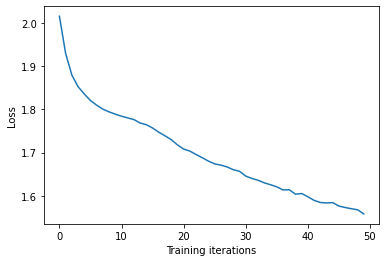

In [16]:
plt.plot(train_loss)
plt.xlabel("Training iterations")
plt.ylabel("Loss")
plt.show()

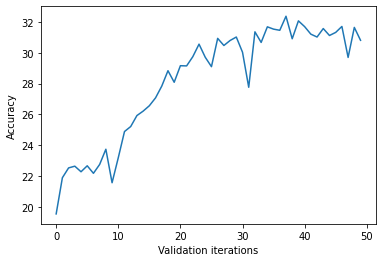

In [17]:
plt.plot(val_accuracy)
plt.xlabel("Validation iterations")
plt.ylabel("Accuracy")
plt.show()

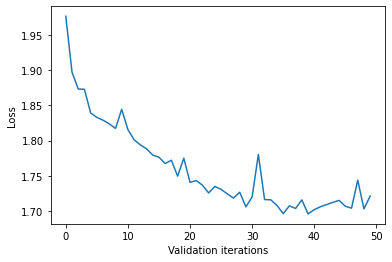

In [18]:
plt.plot(val_loss)
plt.xlabel("Validation iterations")
plt.ylabel("Loss")
plt.show()

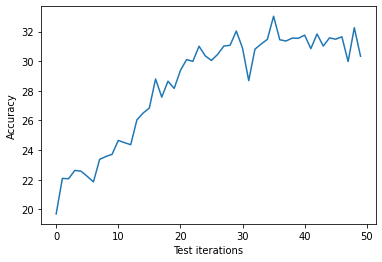

In [19]:
plt.plot(test_acc)
plt.xlabel("Test iterations")
plt.ylabel("Accuracy")
plt.show()